In [1]:
%matplotlib inline
import os
import sys
curr_path = os.getcwd()
gerkin_path = os.path.split(curr_path)[0]
olfaction_prediction_path = os.path.split(gerkin_path)[0]
sys.path.append(olfaction_prediction_path)
import opc_python
import numpy as np
import matplotlib.pyplot as plt
import pandas
from opc_python.utils import loading, scoring
from opc_python.gerkin import dream,fit1,fit2,params

In [2]:
# Get all Chemical IDs and located the data directory.  
all_CIDs = sorted(loading.get_CIDs('training')+loading.get_CIDs('leaderboard')+loading.get_CIDs('testset'))
mdx = dream.get_molecular_data(['dragon','episuite','morgan','nspdk','gramian'],all_CIDs)

Episuite has 62 features for 476 molecules.
Morgan has 2437 features for 476 molecules.
NSPDK has 6163 features for 476 molecules.
NSPDK Gramian has 2437 features for 476 molecules.
There are now 15969 total features.


### Create matrices

In [3]:
# Create the feature matrices from the feature dicts.  
# Create the feature matrices from the feature dicts.  
X_train,good1,good2,means,stds,imputer = dream.make_X(mdx,['training-norep','leaderboard'])
X_test_other,good1,good2,means,stds,imputer = dream.make_X(mdx,"replicated",target_dilution='high',good1=good1,good2=good2,means=means,stds=stds)
X_test_int,good1,good2,means,stds,imputer = dream.make_X(mdx,"replicated",target_dilution=-3,good1=good1,good2=good2,means=means,stds=stds)

The X matrix now has shape (774x14096) molecules by non-NaN good molecular descriptors
The X matrix now has shape (20x14096) molecules by non-NaN good molecular descriptors
The X matrix now has shape (15x14096) molecules by non-NaN good molecular descriptors


In [4]:
# Create descriptor matrices for the training set.  
# One is done with median imputation, and the other by masking missing values.  
Y_train_imp,imputer = dream.make_Y_obs(['training-norep','leaderboard'],target_dilution=None,imputer='median')
Y_train_mask,imputer = dream.make_Y_obs(['training-norep','leaderboard'],target_dilution=None,imputer='mask')

The Y['mean_std'] matrix now has shape (774x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (774x21) molecules by perceptual descriptors, one for each subject
The Y['mean_std'] matrix now has shape (774x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (774x21) molecules by perceptual descriptors, one for each subject


In [5]:
# Create descriptor matrices for the leaderboard set.  
# One is done with median imputation, and the other with no imputation 
Y_test_other,imputer = dream.make_Y_obs('replicated',target_dilution='high',imputer='mask')
Y_test_other_noimpute,_ = dream.make_Y_obs('replicated',target_dilution='high',imputer=None)
Y_test_int,imputer = dream.make_Y_obs('replicated',target_dilution=-3,imputer='mask')
Y_test_int_noimpute,_ = dream.make_Y_obs('replicated',target_dilution=-3,imputer=None)

The Y['mean_std'] matrix now has shape (20x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (20x21) molecules by perceptual descriptors, one for each subject
The Y['mean_std'] matrix now has shape (20x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (20x21) molecules by perceptual descriptors, one for each subject
The Y['mean_std'] matrix now has shape (15x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (15x21) molecules by perceptual descriptors, one for each subject
The Y['mean_std'] matrix now has shape (15x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (15x21) molecules by perceptual descriptors, one for each subject


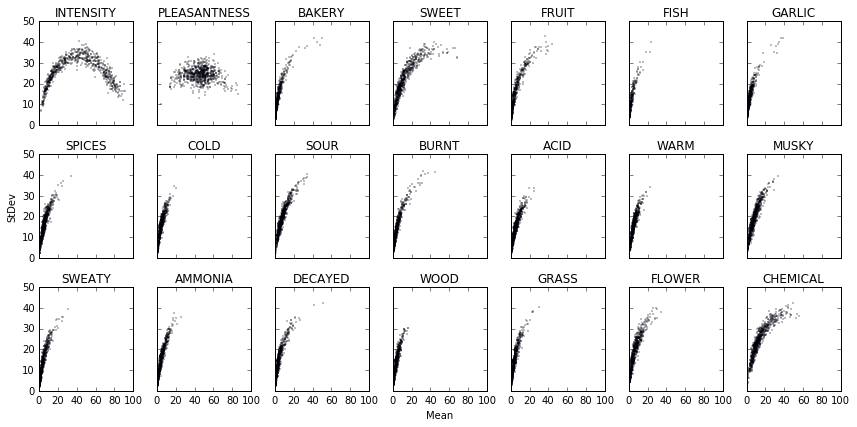

In [6]:
perceptual_headers,_ = loading.load_perceptual_data('training')
Y = Y_train_mask

# Plot stdev vs mean for each descriptor, and fit to a theoretically-motivated function.  
# These fit parameters will be used in the final model fit.  
def f_transformation(x, k0=1.0, k1=1.0):
    return 100*(k0*(x/100)**(k1*0.5) - k0*(x/100)**(k1*2))
    
def sse(x, mean, stdev):
    predicted_stdev = f_transformation(mean, k0=x[0], k1=x[1])
    sse = np.sum((predicted_stdev - stdev)**2)
    return sse
    
fig,axes = plt.subplots(3,7,sharex=True,sharey=True,figsize=(12,6))
ax = axes.flat
trans_params = {col:None for col in range(21)}
from scipy.optimize import minimize
for col in range(len(ax)):    
    Y_mean = Y['mean_std'][:,col]
    Y_stdev = Y['mean_std'][:,col+21]
    x = [1.0,1.0]
    res = minimize(sse, x, args=(Y_mean,Y_stdev), method='L-BFGS-B')
    trans_params[col] = res.x # We will use these for our transformations.  
    ax[col].scatter(Y_mean,Y_stdev,s=0.1)
    x_ = np.linspace(0,100,100)
    #ax[col].plot(x_,f_transformation(x_, k0=res.x[0], k1=res.x[1]))
    ax[col].set_title(perceptual_headers[col+6].split('/')[1 if col==1 else 0])
    ax[col].set_xlim(0,100)
    ax[col].set_ylim(0,50)
    if col == 17:
        ax[col].set_xlabel('Mean')
    if col == 7:
        ax[col].set_ylabel('StDev')
plt.tight_layout()

In [7]:
# Load optimal parameters (obtained from extensive cross-validation).
cols = range(42)
def get_params(i):
    return {col:params.best[col][i] for col in cols}

use_et = get_params(0)
max_features = get_params(1)
max_depth = get_params(2)
min_samples_leaf = get_params(3)
trans_weight = get_params(4)
regularize = get_params(4)
use_mask = get_params(5)
for col in range(21):
    trans_weight[col] = trans_weight[col+21]

In [8]:
n_estimators = 500
rfcs_norep,score,rs = fit2.rfc_final(X_train,Y_train_imp['mean_std'],
                                           Y_train_mask['mean_std'],max_features,
                                           min_samples_leaf,max_depth,use_et,use_mask,
                                           trans_weight,trans_params,
                                           n_estimators=n_estimators)

97.62% [------------------------------------------------- ]For subchallenge 2:
	Score = 14.65
	int_mean = 1.000
	int_sigma = 0.938
	ple_mean = 0.970
	ple_sigma = 0.781
	dec_mean = 0.820
	dec_sigma = 0.737


In [9]:
# Make challenge 2 leaderboard prediction files from the models.  
# There are 20 replications for the high concentration, but only 15 for the 1/1000
# concentration, so these have to be computed separately.  
Y_pred_int = loading.make_prediction_files(rfcs_norep,X_test_int,X_test_int,
                              'replicated_int',2,Y_test=Y_test_int_noimpute,
                              write=False,trans_weight=trans_weight,trans_params=trans_params)

Y_pred_other = loading.make_prediction_files(rfcs_norep,X_test_other,X_test_other,
                              'replicated_other',2,Y_test=Y_test_other_noimpute,
                              write=False,trans_weight=trans_weight,trans_params=trans_params)

Y = Y_pred_other['mean_std']
Y_pred = np.ma.array(Y,mask=np.zeros(Y.shape))
Y_pred[:15,0:42:21] = Y_pred_int['mean_std'][:,0:42:21]
Y_pred.mask[15:,0:42:21] = True

Y = Y_test_other_noimpute['mean_std']
Y_obs = np.ma.array(Y,mask=np.zeros(Y.shape))
Y_obs[:15,0:42:21] = Y_test_int_noimpute['mean_std'][:,0:42:21]
Y_obs.mask[15:,0:42:21] = True

scoring.score_summary2(Y_pred,Y_obs,mask=True)

Score: 7.099141; rs = 0.585,0.704,0.489,-0.467,0.339,0.411
Score: 8.285237; rs = 0.141,0.760,0.588,-0.063,0.359,0.499


'Score: 8.346232; rs = 0.585,0.760,0.588,-0.467,0.359,0.499'

In [20]:
# Predictions by descriptor for the replicated molecules.
for col in range(21):
    print('%d mean: %.4f' % (col,scoring.r2(col,'mean',Y_pred,Y_obs,mask=True)))
for col in range(21):
    print('%d sigma: %.4f' % (col,scoring.r2(col,'sigma',Y_pred,Y_obs,mask=True)))

0 mean: 0.5853
1 mean: 0.7602
2 mean: 0.6940
3 mean: 0.8135
4 mean: 0.8756
5 mean: 0.4513
6 mean: 0.9652
7 mean: 0.4577
8 mean: 0.5091
9 mean: 0.4563
10 mean: 0.3301
11 mean: 0.5045
12 mean: 0.1987
13 mean: 0.6104
14 mean: 0.7700
15 mean: 0.4369
16 mean: 0.7168
17 mean: 0.5731
18 mean: 0.5422
19 mean: 0.5447
20 mean: 0.7168
0 sigma: -0.4670
1 sigma: 0.3593
2 sigma: 0.5767
3 sigma: 0.5439
4 sigma: 0.6183
5 sigma: 0.3538
6 sigma: 0.8011
7 sigma: 0.4449
8 sigma: 0.4910
9 sigma: 0.4258
10 sigma: 0.4097
11 sigma: 0.3265
12 sigma: 0.1014
13 sigma: 0.6603
14 sigma: 0.7909
15 sigma: 0.3998
16 sigma: 0.5685
17 sigma: 0.5075
18 sigma: 0.4527
19 sigma: 0.5578
20 sigma: 0.4413
